In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import os
import glob
import sys
from datetime import date
import json

import neuraltoolkit as ntk

from scipy.stats import ranksums

import eccojams as eco

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Arial'})

today = date.today()
today = today.strftime("%Y_%m_%d")

basedir = os.path.dirname(os.path.dirname(os.getcwd()))
pth = f'{basedir}/notebooks/figure_3/'

In [2]:
#--------------------- Colors ---------------------

with open(f'{basedir}/colormaps/geno_colors.json') as json_file:
    geno_clrs = json.load(json_file)

dump = 0

In [3]:
#Load downsampled data
rawca1 = np.load(f'/{basedir}/data/CAF77/0202/12_24/raw/2021-02-03_02-28-25_ca1_raw.npy')

SAMPLING_FREQUENCY = 1500
nsec = 5*60
n_samples = int(SAMPLING_FREQUENCY * nsec)

spikes_ca1 = f'/{basedir}/data/CAF77/0202/12_24/raw/H_2021-02-03_02-28-25_2021-02-03_14-18-25_neurons_group0.npy'
nlist = np.load(spikes_ca1, allow_pickle='True')
nrns_ca1 = eco.nrnlist_by_region(nlist,'CA1')

In [4]:
#Simulate time
simtime = eco.simulate_time(n_samples, SAMPLING_FREQUENCY)

#Find ripples
filtered_rip = ntk.butter_bandpass(rawca1, 150, 250, SAMPLING_FREQUENCY, order = 3)
filtered_rip = filtered_rip.T

#filter lFP 1 to 500Hz
rawca1_bp = ntk.butter_bandpass(rawca1, 1, 500, SAMPLING_FREQUENCY, order = 3)

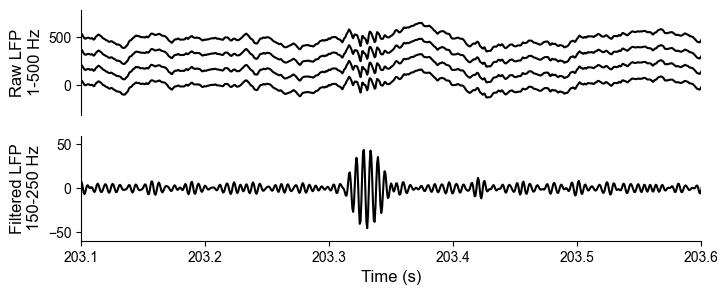

In [5]:
#Single ripple plot

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(8, 3), sharex=True)
ax[0].plot(simtime, rawca1_bp.T[:,:4] + np.tile(np.arange(0,654,(654/4)),450000).reshape(450000,4),color='black')
ax[1].plot(simtime, np.mean(filtered_rip[:,:4],axis=1),color='black')

plt.xlim(203.1,203.6)
# ax[0].set_ylim(-350,300)
ax[1].set_ylim(-60,60)

ax[0].set_ylabel('Raw LFP\n1-500 Hz',fontsize=12)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].xaxis.set_visible(False)
ax[1].set_ylabel('Filtered LFP\n150-250 Hz',fontsize=12)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel('Time (s)',fontsize=12)

if dump:
    filename = '_ripple_example.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass

plt.show()

/tmp/ipykernel_21655/3390527280.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spikeraster = np.asarray(spike_timestamps)


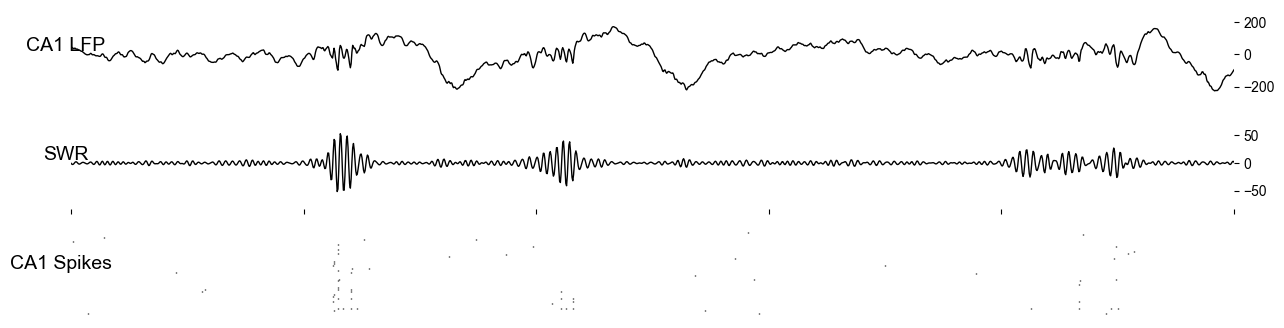

In [6]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(15, 4), sharex=True)

ax[0].plot(simtime, np.mean(rawca1_bp.T[:,:4],axis=1),color='black',linewidth=1)
ax[0].set_ylabel('CA1 LFP',rotation=0,fontsize=14)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].yaxis.tick_right()
ax[0].xaxis.set_visible(False)

ax[1].plot(simtime, np.mean(filtered_rip[:,:4],axis=1),color='black',linewidth=1)
ax[1].set_ylabel('SWR',rotation=0,fontsize=14)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].yaxis.tick_right()
# ax[1].xaxis.set_visible(False)

starttime = 43
endtime = 44
cellstoplot = nrns_ca1
spike_timestamps = []
for cellnum in np.arange(len(cellstoplot)):
    index = (cellstoplot[cellnum].spike_time_sec>starttime)&(cellstoplot[cellnum].spike_time_sec<endtime)
    spikes = cellstoplot[cellnum].spike_time_sec[index]
    spike_timestamps.append(spikes)
spikeraster = np.asarray(spike_timestamps)

colors2 = [[0, 0, 0]]
# ax[2].eventplot(spikeraster[-7:],colors=colors2,lineoffsets=1,linelengths=0.5,linewidths=1)
ax[2].eventplot(spikeraster,colors=colors2,lineoffsets=1,linelengths=0.5,linewidths=1)

ax[2].set_ylabel('CA1 Spikes',rotation=0,fontsize=14)
ax[2].set_yticks([])
ax[2].spines['top'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].xaxis.set_visible(False)

# ax[2].plot(vel_xy_scaled)
# plt.xlim(40,50)
plt.xlim(43,44)
# plt.xlim(71.5,75.5)

if dump:
    filename = 'ripple_and_lfp_tseries.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass

plt.show()

In [7]:
dirlist = glob.glob(f'/{basedir}/data/*/*/*_*/')
wt = ['CAF69','CAF77','CAF81','CAF82']
app = ['CAF71','CAF73','CAF74','CAF75']

In [8]:
genos = []
animals = []
states = []
epochnames = []
nrips = []
ripdens = []
lenmeans = []
lenstds = []
ampmeans = []
ampstds = []

for epochdir in dirlist:
    epochname = epochdir.split('appps1/data/')[-1].replace('_','-').replace('/','_')[:-1]
    animal = epochname.split('_')[0]
    if animal in wt:
        geno='wt'
    elif animal in app:
        geno='app'
        
    ripplebois = glob.glob(epochdir + '*ripple_times*.csv')[0]
    sleepybois = glob.glob(epochdir + '*sleep.npy')[0]
    riptimes = eco.get_riptimes(ripplebois)
    sleepdf = eco.get_sleeptimes(sleepybois)

    sleepstates = ['nrem','active','rem']

    for state in sleepstates:

        riptimes_state = eco.riptimes_by_state(riptimes,sleepdf,state)
        n_rips = len(riptimes_state)
        if n_rips > 0:
            reclen = np.round(np.max(riptimes_state.peak_time))
            ripbinned = eco.bin_spikes_1d(riptimes_state.peak_time,binsize=60,tspan= reclen)
            rip_dens = np.mean(ripbinned[ripbinned>0])

            genos.append(geno)
            animals.append(animal)
            states.append(state)
            epochnames.append(epochname)
            nrips.append(n_rips)
            ripdens.append(rip_dens)
            lenmeans.append(np.mean(riptimes_state.length) * 1000)
            lenstds.append(np.std(riptimes_state.length))
            ampmeans.append(np.mean(riptimes_state.amplitude))
            ampstds.append(np.std(riptimes_state.amplitude))

ripdf = pd.DataFrame({'geno': genos, 'animal': animals, 'state': states, 'epoch': epochnames,'n_ripples': nrips,
                     'density': ripdens, 'duration': lenmeans, 'amplitude': ampmeans})

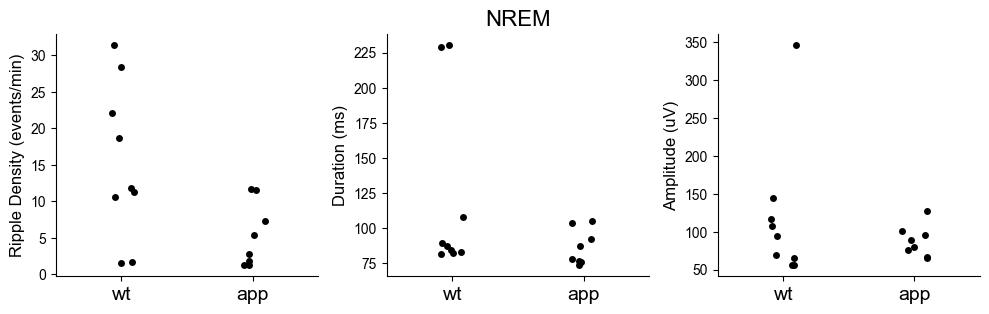

In [9]:
# for sleepstate in ['nrem','active','rem']:
    
sleepstate = 'nrem'

# ripdf_agg = ripdf[ripdf.state==sleepstate].groupby(['animal','geno']).aggregate('mean').reset_index()
ripdf_agg = ripdf[ripdf.state==sleepstate]


fig, ax = plt.subplots(nrows=1, ncols = 3, figsize=(10,3))

sns.stripplot(ax = ax[0], x="geno", y="density", data=ripdf_agg,
              color='black',order=['wt','app'])
ax[0].set_ylabel('Ripple Density (events/min)',fontsize=12)

sns.stripplot(ax = ax[1], x="geno", y="duration", data=ripdf_agg,
              color='black',order=['wt','app'])
ax[1].set_ylabel('Duration (ms)',fontsize=12)

sns.stripplot(ax = ax[2], x="geno", y="amplitude", data=ripdf_agg,
             color='black',order=['wt','app'])
ax[2].set_ylabel('Amplitude (uV)',fontsize=12)

for j in range(len(ax)):
    ax[j].set_xlabel('')
    ax[j].tick_params(axis='x', which='major', labelsize=14)

plt.tight_layout()
ax[1].set_title(sleepstate.upper(),fontsize=16)
sns.despine()

if dump:
    filename = f'ripple_stats_{sleepstate}.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass
plt.show()

In [10]:
binsize=0.001
peri_rip_time = 0.5
epochlen = int(2*peri_rip_time/binsize)

epochdir = f'/{basedir}/data/CAF71/0103/12_20/'
ripplebois = glob.glob(epochdir + '*ripple_times*.csv')[0]
sleepybois = glob.glob(epochdir + '*sleep.npy')[0]
spikybois = glob.glob(epochdir + '*singleunits.npy')[0]
riptimes = eco.get_riptimes(ripplebois, ampthresh = 50)
sleepdf = eco.get_sleeptimes(sleepybois)
riptimes_state = eco.riptimes_by_state(riptimes,sleepdf,'nrem')
nrn = np.load(spikybois, allow_pickle=True)
nrn_rsc = eco.nrnlist_by_region(nrn,'RSC')
# nrn_acc = nrnlist_by_region(nrn,'ACC')
# nrn_v1 = nrnlist_by_region(nrn,'V1')

### subset ripples
if len(riptimes_state) < 500:
    rip_subset = riptimes_state.sort_values('amplitude')
else:
    rip_subset = riptimes_state.sort_values('amplitude')[-500:]
    
### bin and align data to ripples
bin_rsc = eco.bin_and_align_spikes(nrn_rsc,rip_subset.peak_time.values,binsize,peri_rip_time)

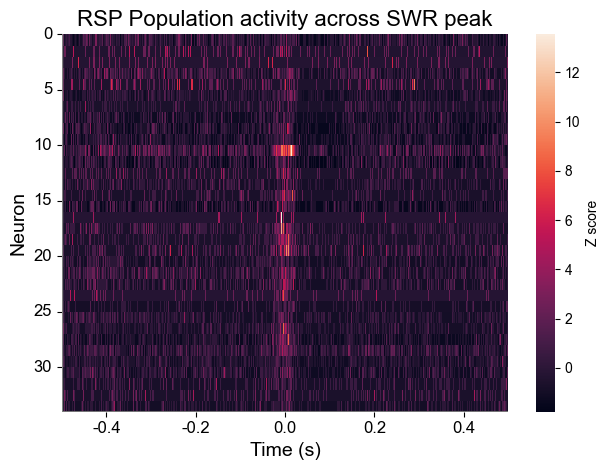

In [11]:
xticklabs = np.round(np.hstack([np.arange(-0.4,0,0.2),
                                np.arange(0,0.41,0.2)]),2)
xtickpos = (xticklabs + peri_rip_time) * 1000
nrips = bin_rsc.shape[2]
ncell = bin_rsc.shape[0]

#plot each neurons' average response across ripples
# peth = eco.zscore_from_peth(np.mean(bin_rsc,axis=2),binsize)
peth = eco.zscore_to_flank(np.mean(bin_rsc,axis=2))
sns.heatmap(peth,cbar_kws={'label': 'Z score'})
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Neuron',fontsize=14)
plt.title('RSP Population activity across SWR peak',fontsize=16)

plt.axhline(ncell, color = 'grey',linewidth = 2)
plt.axvline(0, color = 'grey',linewidth = 1)

yticklabs = np.arange(0,ncell,5)
plt.xticks(xtickpos,xticklabs,rotation=0,fontsize=12)
plt.yticks(yticklabs,yticklabs,rotation=0,fontsize=12)
plt.tight_layout()
if dump:
    filename = '_ripple_peth_allnrn.pdf'
    plt.savefig( pth+today+filename)

else:
    pass
plt.show()
# plt.close()
# plt.clf()

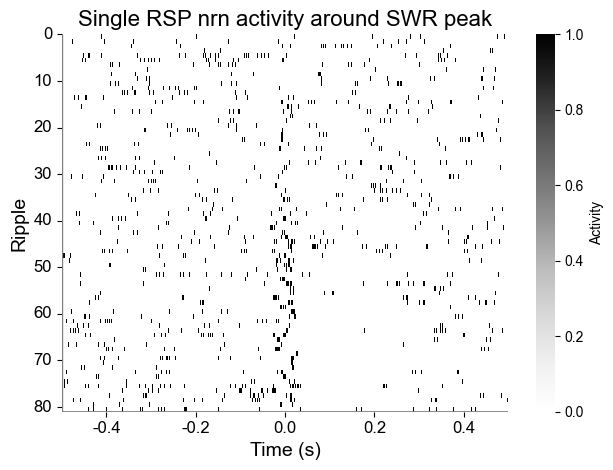

In [12]:
#plot a single neuron (time X ripples)
bestcell = np.argmax(np.max(peth,axis=1))
sns.heatmap(bin_rsc[10,:,:].T,cbar_kws={'label': 'Activity'},cmap="Greys")
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Ripple',fontsize=14)
plt.title(f'Single RSP nrn activity around SWR peak',fontsize=16)

plt.axhline(nrips, color = 'grey',linewidth = 2)
plt.axvline(0, color = 'grey',linewidth = 1)

yticklabs = np.arange(0,nrips,10)
plt.xticks(xtickpos,xticklabs,rotation=0,fontsize=12)
plt.yticks(yticklabs,yticklabs,rotation=0,fontsize=12)
plt.tight_layout()

if dump:
    filename = '_ripple_peth_singlenrn.pdf'
    plt.savefig(pth+today+filename,dpi=300,bbox_inches='tight')
else:
    pass
plt.show()
# plt.close()
# plt.clf()

In [13]:
ripdir = f'/{basedir}/data/ripple/'
wt = ['CAF69','CAF77','CAF81','CAF82']
app = ['CAF71','CAF73','CAF74','CAF75']

Peak offset wilcoxon: 5.525072691839671, p = 3.293492209851096e-08
Median offset WT = 13
Median offset APP = -8
sem offset WT = 3.273691699012026
sem offset APP = 2.05568646878148


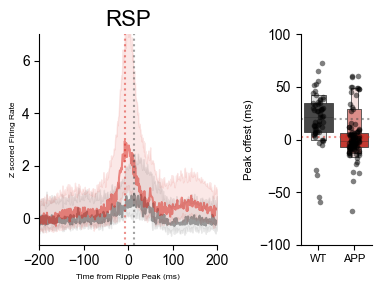

Peak offset wilcoxon: -6.526443497857745, p = 6.734970634836764e-11
Median offset WT = -74
Median offset APP = 5
sem offset WT = 4.754269875506248
sem offset APP = 2.5868549827010194


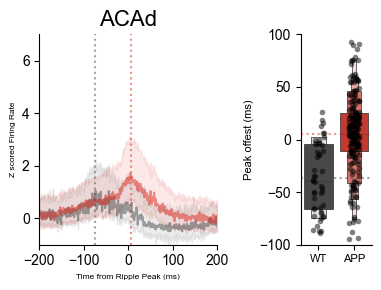

Peak offset wilcoxon: -0.9377347200721312, p = 0.3483807562269783
Median offset WT = 2
Median offset APP = 2
sem offset WT = 4.912088509418486
sem offset APP = 3.3291425178768534


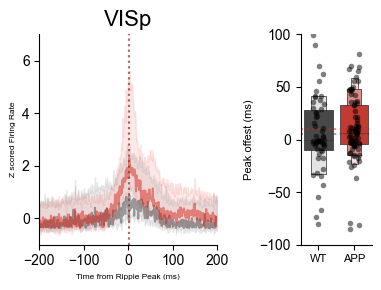

In [14]:
for r,region in enumerate(['RSC','ACC','V1']):


    titles = ['RSP','ACAd','VISp']
    title = titles[r]

    wt_rsu_dat, app_rsu_dat = eco.get_peth_data(ripdir,wt,app,'NREM',region,'RSU')
    wt_rsu_z = eco.zscore_from_peth(wt_rsu_dat,binsz=0.001)
    app_rsu_z = eco.zscore_from_peth(app_rsu_dat,binsz=0.001)
    wt_rsu_z_sm = eco.smooth_spikes(wt_rsu_z,binsize=0.001,sigma=0.005)
    app_rsu_z_sm = eco.smooth_spikes(app_rsu_z,binsize=0.001,sigma=0.005)
    
    
    peaks_wt_rsu = np.max(wt_rsu_z,axis=1)
    peaks_app_rsu = np.max(app_rsu_z,axis=1)
    peakpos_wt_rsu = np.argmax(wt_rsu_z,axis=1)
    peakpos_app_rsu = np.argmax(app_rsu_z,axis=1)

    wtdat = wt_rsu_z
    appdat = app_rsu_z

    # threshcriteria = np.mean(np.hstack([wtdat[:,:200],wtdat[:,-200:]]),axis=1) < np.mean(wtdat[:,950:1050],axis=1)
    threshcriteria =  np.max(wtdat[:,950:1050],axis=1) > 2*np.std(np.hstack([wtdat[:,:100],wtdat[:,-100:]]),axis=1)
    wtdat = wtdat[threshcriteria]
    peakpos_wt_rsu = peakpos_wt_rsu[threshcriteria]
    # threshcriteria = np.mean(np.hstack([appdat[:,:200],appdat[:,-200:]]),axis=1) < np.mean(appdat[:,950:1050],axis=1)
    threshcriteria =  np.max(appdat[:,950:1050],axis=1) > 2*np.std(np.hstack([appdat[:,:100],appdat[:,-100:]]),axis=1)
    appdat = appdat[threshcriteria]
    peakpos_app_rsu = peakpos_app_rsu[threshcriteria]


    peakpos = np.hstack([(peakpos_wt_rsu - 1000),(peakpos_app_rsu - 1000)])
    condlist = np.hstack([np.tile('WT',len(peakpos_wt_rsu)),np.tile('APP',len(peakpos_app_rsu))])
    reglist = np.tile(title,len(peakpos_wt_rsu)+len(peakpos_app_rsu))
    peakdf = pd.DataFrame({'region': reglist, 'genotype': condlist, 'peakpos': peakpos})
    peakdf = peakdf[(peakdf.peakpos > -100) & (peakdf.peakpos < 100)]

    x = np.arange(-200,200)
    
    wtdat2 = wtdat[:,800:1200]
    appdat2 = appdat[:,800:1200]
    
    stdev_wt = np.std(wtdat2,axis=0)/np.sqrt(4)
    stdev_app = np.std(appdat2,axis=0)/np.sqrt(4)

    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(4,3), gridspec_kw={'width_ratios':[2,0.8]})

    ax[0].plot(x, np.median(wtdat2,axis=0),c=geno_clrs['WT'],alpha=0.5,label='WT')
    ax[0].plot(x, np.median(appdat2,axis=0),c=geno_clrs['APP'],alpha=0.5,label='APP')
    ax[0].fill_between(x, np.mean(wtdat2,axis=0) - stdev_wt, np.mean(wtdat2,axis=0) + stdev_wt,
    color=geno_clrs['WT'],alpha=0.1)
    ax[0].fill_between(x,np.mean(appdat2,axis=0) - stdev_app, np.mean(appdat2,axis=0) + stdev_app,
    color=geno_clrs['APP'],alpha=0.1)
    ax[0].set_xlabel('Time from Ripple Peak (ms)',fontsize=6)
    ax[0].set_ylabel('Z scored Firing Rate',fontsize=6)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)

    ax[0].set_title(title,fontsize=16)

    ax[0].axvline(np.argmax(np.median(wtdat2,axis=0))-200,c=geno_clrs['WT'],
                  alpha=0.5,linestyle='dotted')
    ax[0].axvline(np.argmax(np.median(appdat2,axis=0))-200,c=geno_clrs['APP'],
                  alpha=0.5,linestyle='dotted')
    ax[0].set_xlim(-200,200)
    ax[0].set_ylim(-1,7)

    sns.boxenplot(ax = ax[1], data = peakdf, x = 'genotype', y = 'peakpos', 
                  showfliers = False, linewidth = 0.5, palette = geno_clrs)
    sns.stripplot(ax = ax[1], data = peakdf, x = 'genotype', dodge = True, y = 'peakpos', 
                  color = 'black', alpha = 0.5, size=4, jitter = 0.15)

    ax[1].axhline(np.mean(peakdf[peakdf.genotype=='WT'].peakpos),color = geno_clrs['WT'],
                  alpha=0.5,linestyle='dotted')
    ax[1].axhline(np.mean(peakdf[peakdf.genotype=='APP'].peakpos),color = geno_clrs['APP'],
                  alpha=0.5,linestyle='dotted')

    ax[1].set_ylim(-100,100)
    ax[1].set_ylabel('Peak offest (ms)', fontsize = 8)
    ax[1].set_xlabel('')
    ax[1].get_xaxis().set_ticklabels(['WT','APP'],fontsize=8)

    pos_stat, pos_p = ranksums(peakdf[peakdf.genotype=='WT'].peakpos,
                               peakdf[peakdf.genotype=='APP'].peakpos)

    print(f'Peak offset wilcoxon: {pos_stat}, p = {pos_p}')
    print("Median offset WT = " + str(np.argmax(np.median(wtdat2,axis=0))-200))
    print("Median offset APP = " + str(np.argmax(np.median(appdat2,axis=0))-200))
    print("sem offset WT = " + str(np.std(peakdf[peakdf.genotype=='WT'].peakpos)/np.sqrt(len(peakdf[peakdf.genotype=='WT']))))
    print("sem offset APP = " + str(np.std(peakdf[peakdf.genotype=='APP'].peakpos)/np.sqrt(len(peakdf[peakdf.genotype=='APP']))))

    sns.despine()
    plt.tight_layout()

    if dump:
        filename = f'swrpeak_by_genotype_{title}.pdf'
        plt.savefig(pth+today+filename)
    else:
        pass

    plt.show()

RSP
Peak height wilcoxon: -3.1488762932639203, p = 0.0016389956057885496
Median height WT = 6.18115245688562
Median height APP = 7.496950291199566
sem height WT = 0.30624086119431904
sem height APP = 0.3814660177996768
ACAd
Peak height wilcoxon: -0.9506890540681798, p = 0.34176224636161345
Median height WT = 5.516709796352783
Median height APP = 5.615110029518723
sem height WT = 0.20626007845317812
sem height APP = 0.27523046485946334
VISp
Peak height wilcoxon: -2.0121474077088366, p = 0.044204400512425565
Median height WT = 6.601302829364611
Median height APP = 7.594376617802
sem height WT = 0.38539278450343406
sem height APP = 0.43022066353210536


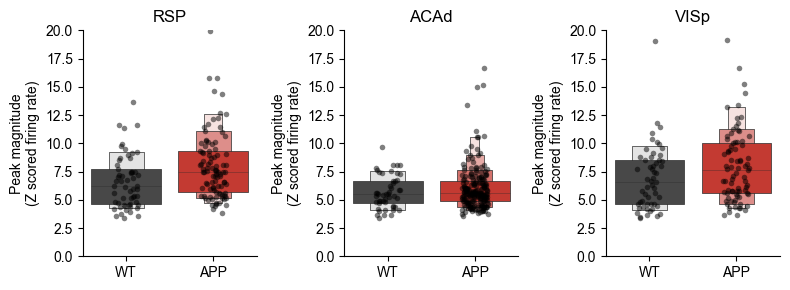

In [15]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(8,3))

for r,region in enumerate(['RSC','ACC','V1']):


    titles = ['RSP','ACAd','VISp']
    title = titles[r]

    wt_rsu_dat, app_rsu_dat = eco.get_peth_data(ripdir,wt,app,'NREM',region,'RSU')
    wt_rsu_z = eco.zscore_from_peth(wt_rsu_dat,binsz=0.001)
    app_rsu_z = eco.zscore_from_peth(app_rsu_dat,binsz=0.001)
    
    peaks_wt_rsu = np.max(wt_rsu_z,axis=1)
    peaks_app_rsu = np.max(app_rsu_z,axis=1)
    peakpos_wt_rsu = np.argmax(wt_rsu_z,axis=1)
    peakpos_app_rsu = np.argmax(app_rsu_z,axis=1)

    wtdat = wt_rsu_z
    appdat = app_rsu_z

    # threshcriteria = np.mean(np.hstack([wtdat[:,:200],wtdat[:,-200:]]),axis=1) < np.mean(wtdat[:,950:1050],axis=1)
    threshcriteria =  np.max(wtdat[:,950:1050],axis=1) > 2*np.std(np.hstack([wtdat[:,:100],wtdat[:,-100:]]),axis=1)
    wtdat = wtdat[threshcriteria]
    peakpos_wt_rsu = peakpos_wt_rsu[threshcriteria]
    peaks_wt_rsu = peaks_wt_rsu[threshcriteria]
    # threshcriteria = np.mean(np.hstack([appdat[:,:200],appdat[:,-200:]]),axis=1) < np.mean(appdat[:,950:1050],axis=1)
    threshcriteria =  np.max(appdat[:,950:1050],axis=1) > 2*np.std(np.hstack([appdat[:,:100],appdat[:,-100:]]),axis=1)
    appdat = appdat[threshcriteria]
    peakpos_app_rsu = peakpos_app_rsu[threshcriteria]
    peaks_app_rsu = peaks_app_rsu[threshcriteria]


    peakpos = np.hstack([(peakpos_wt_rsu - 1000),(peakpos_app_rsu - 1000)])
    peaks = np.hstack([peaks_wt_rsu, peaks_app_rsu])
    condlist = np.hstack([np.tile('WT',len(peakpos_wt_rsu)),np.tile('APP',len(peaks_app_rsu))])
    reglist = np.tile(title,len(peaks_wt_rsu)+len(peakpos_app_rsu))
    peakdf = pd.DataFrame({'region': reglist, 'genotype': condlist, 'peakpos': peakpos})
    magdf = pd.DataFrame({'region': reglist, 'genotype': condlist, 'peakheight': peaks})
    magdf = magdf[(peakdf.peakpos > -100) & (peakdf.peakpos < 100)]
    magdf = magdf[magdf.peakheight < 20]
    
    sns.boxenplot(ax = ax[r], data = magdf, x = 'genotype', y = 'peakheight', 
                  showfliers = False, linewidth = 0.5, palette = geno_clrs)
    sns.stripplot(ax = ax[r], data = magdf, x = 'genotype', dodge = True, y = 'peakheight', 
                  color = 'black', alpha = 0.5, size=4, jitter = 0.15)

    ax[r].set_ylim(0,20)
    ax[r].set_ylabel('Peak magnitude\n(Z scored firing rate)', fontsize = 10)
    ax[r].set_xlabel('')
    ax[r].get_xaxis().set_ticklabels(['WT','APP'],fontsize=10)
    ax[r].set_title(title)

    peak_stat, peak_p = ranksums(magdf[magdf.genotype=='WT'].peakheight,
                               magdf[magdf.genotype=='APP'].peakheight)

    print(title)
    print(f'Peak height wilcoxon: {peak_stat}, p = {peak_p}')
    print("Median height WT = " + str(np.median(magdf[magdf.genotype=='WT'].peakheight)))
    print("Median height APP = " + str(np.median(magdf[magdf.genotype=='APP'].peakheight)))
    print("sem height WT = " + str(np.std(magdf[magdf.genotype=='WT'].peakheight)/np.sqrt(len(magdf[magdf.genotype=='WT']))))
    print("sem height APP = " + str(np.std(magdf[magdf.genotype=='APP'].peakheight)/np.sqrt(len(magdf[magdf.genotype=='WT']))))

    sns.despine()
plt.tight_layout()

if dump:
    filename = f'swrpeakmag_by_genotype.pdf'
    plt.savefig(pth+today+filename)
else:
    pass

plt.show()